# Image Loading

In [1]:
%matplotlib inline
import numpy as np
import cv2
import skimage.data as data
from skimage.morphology import extrema
from skimage.morphology import watershed as skwater
import skimage.segmentation as seg
import matplotlib.pyplot as plt
import pydicom

# Function

In [2]:
def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.Centre refers to the centre of the circle
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    return np.array([c, r]).T

def image_show(image, nrows=1, ncols=1):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, 9))
    ax.imshow(image)
    ax.axis('off')
    return fig, ax

def ShowImage(title,img,ctype):
  plt.figure(figsize=(9, 9))
  if ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

def filterContours(contours):
    ret = []
    for i in contours:
        if (cv2.contourArea(i) + 1e-8) / (cv2.arcLength(i,True) + 1e-8) > 4:
            ret.append(i)
    return ret

def extractContours(img):
    erosion_size = 1
    erosion_dst = cv2.erode(img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size)))
    #cont = cv2.findContours(erosion_dst, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1];
    
    tmp = cv2.findContours(erosion_dst,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    contours = tmp[0] if len(tmp) == 2 else tmp[1]
    
    
    cont = filterContours(contours)
    ret = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    cv2.drawContours(ret, cont, -1, (255,255,255), -1)
    ret = cv2.dilate(ret, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size)))
    return ret

# Sample Read

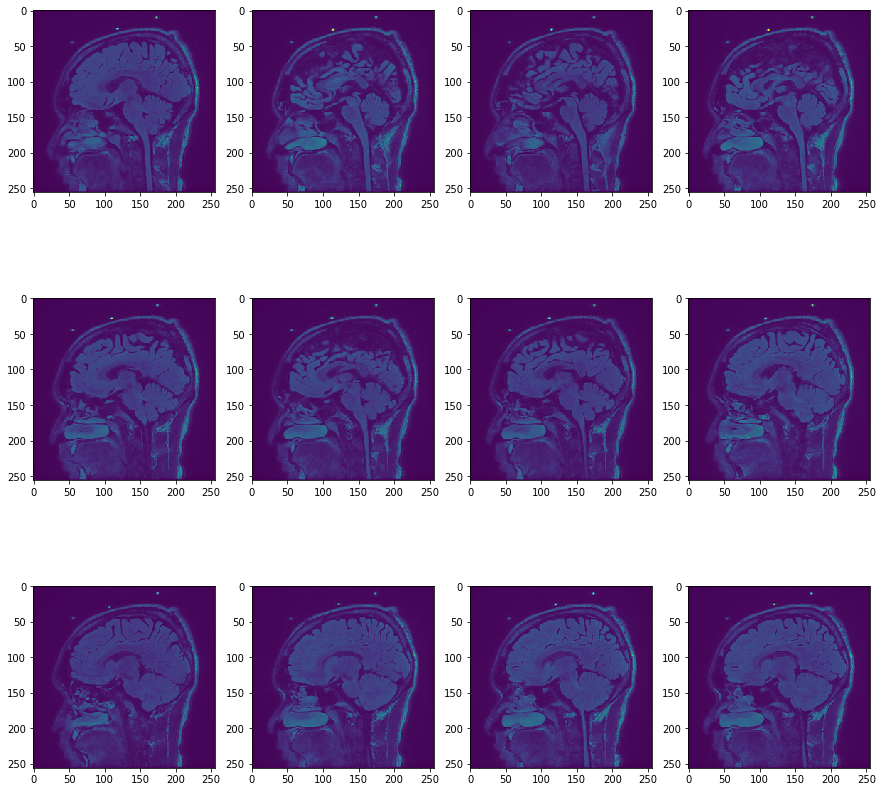

In [5]:
basepath ="C:\\Users\\Asus\\Desktop\\tugas\\RPLB (python)\\dicom\\"
list = ['Z102', 'Z103', 'Z104', 'Z105', 'Z106', 'Z107', 'Z108', 'Z109', 'Z110', 'Z111', 'Z112', 'Z114', 'Z115']
list_a = []

for f in list:
    d = pydicom.read_file(basepath+f)
    a = np.array(d.pixel_array)
    list_a.append(a)
    
w=10
h=10
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(list_a[i])

    

# Preprocessing

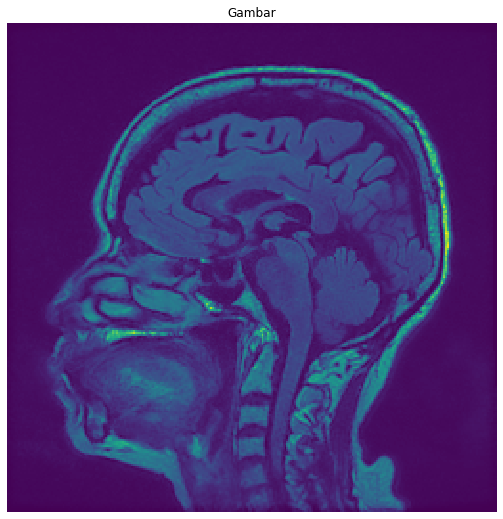

In [8]:
basepath ="C:\\Users\\Asus\\Desktop\\tugas\\RPLB (python)\\dicom\\"
d = pydicom.read_file(basepath + "Z521")
# d = pydicom.read_file(basepath + "Z10")
file = np.array(d.pixel_array)
img = file
ShowImage('Gambar',img,'rgb')
# plt.imshow(img)

# points = circle_points(200, [128, 128], 35)[:-1]
# snake = seg.active_contour(img, points)
# fig, ax = image_show(img)
# ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
# ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

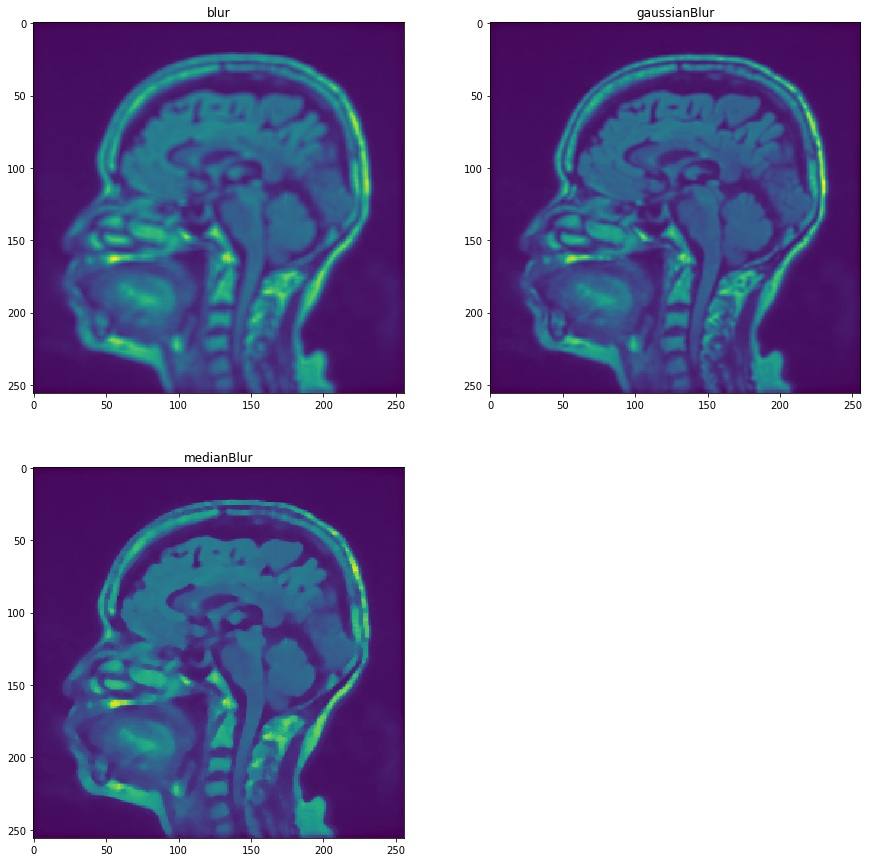

In [9]:
blur = cv2.blur(file,(5,5))
gblur = cv2.GaussianBlur(file,(5,5),0)
median = cv2.medianBlur(file,5)
# bilaterial = cv2.bilateralFilter(file,9,75,75)

fig=plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
plt.title("blur")
plt.imshow(blur)
plt.subplot(2,2,2)
plt.title("gaussianBlur")
plt.imshow(gblur)
plt.subplot(2,2,3)
plt.title("medianBlur")
plt.imshow(median)

In [10]:
img_2d = img.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

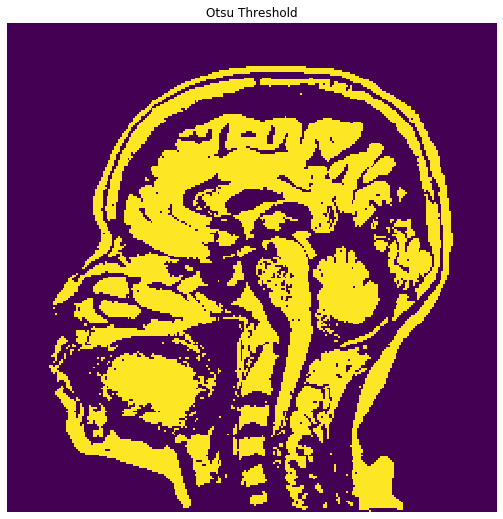

In [11]:
#OTSU THRESHOLDING
_,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
ShowImage('Otsu Threshold',binarized,'rgb')

# Dari Asli ke Filter

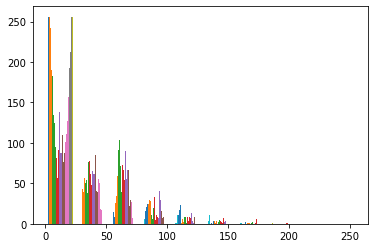

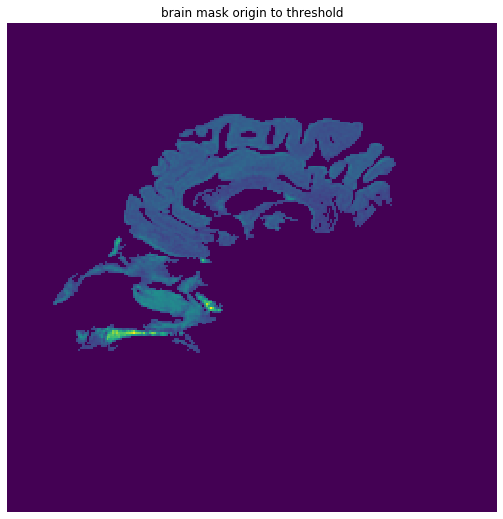

In [12]:
plt.hist(hasil)

thresh = binarized
gambar1 = hasil
#Get brain
ret, markers = cv2.connectedComponents(thresh)

#Get the area taken by each component. Ignore label 0 since this is the background.
marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0]

#Get label of largest component by area
largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        

#Get pixels which correspond to the brain
brain_mask = markers==largest_component
otak = gambar1.copy()

#In a copy of the original image, clear those pixels that don't correspond to the brain
# otak[brain_mask==False]=(0,0,0)
otak[brain_mask==False] = 0
ShowImage('brain mask origin to threshold',otak,'rgb')

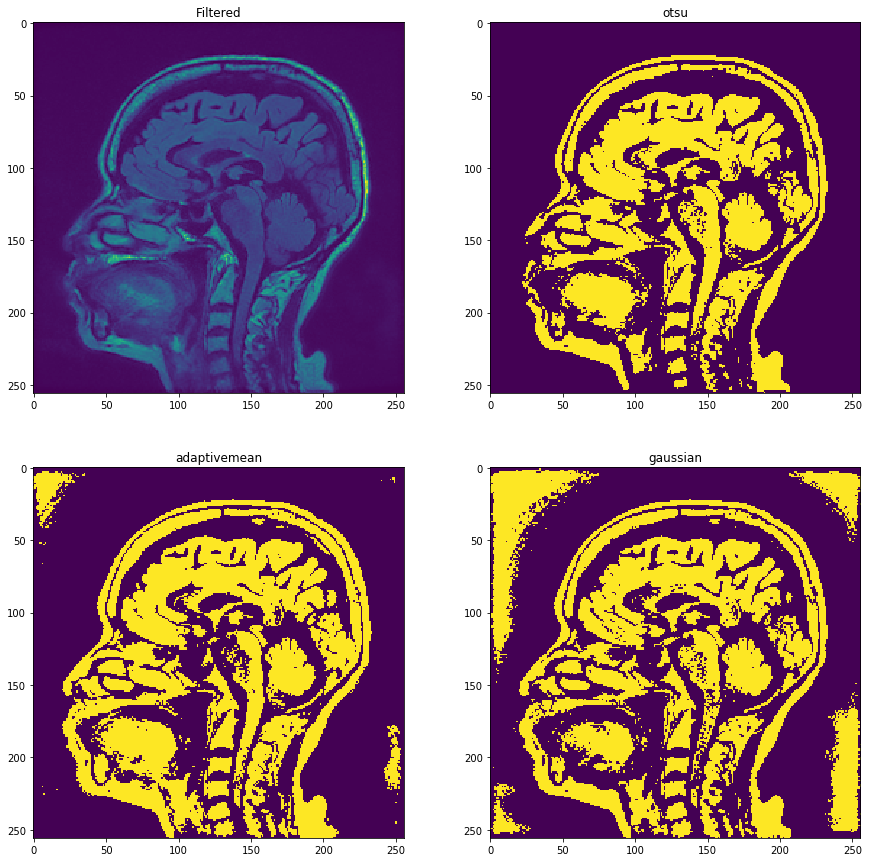

In [13]:
#threholding lain
_,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
adaptiveMean = cv2.adaptiveThreshold(hasil,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,115, 1)
gaussian = cv2.adaptiveThreshold(hasil,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,115, 1)

fig=plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
plt.title("Filtered")
plt.imshow(hasil)
plt.subplot(2,2,2)
plt.title("otsu")
plt.imshow(binarized)
plt.subplot(2,2,3)
plt.title("adaptivemean")
plt.imshow(adaptiveMean)
plt.subplot(2,2,4)
plt.title('gaussian')
plt.imshow(gaussian)


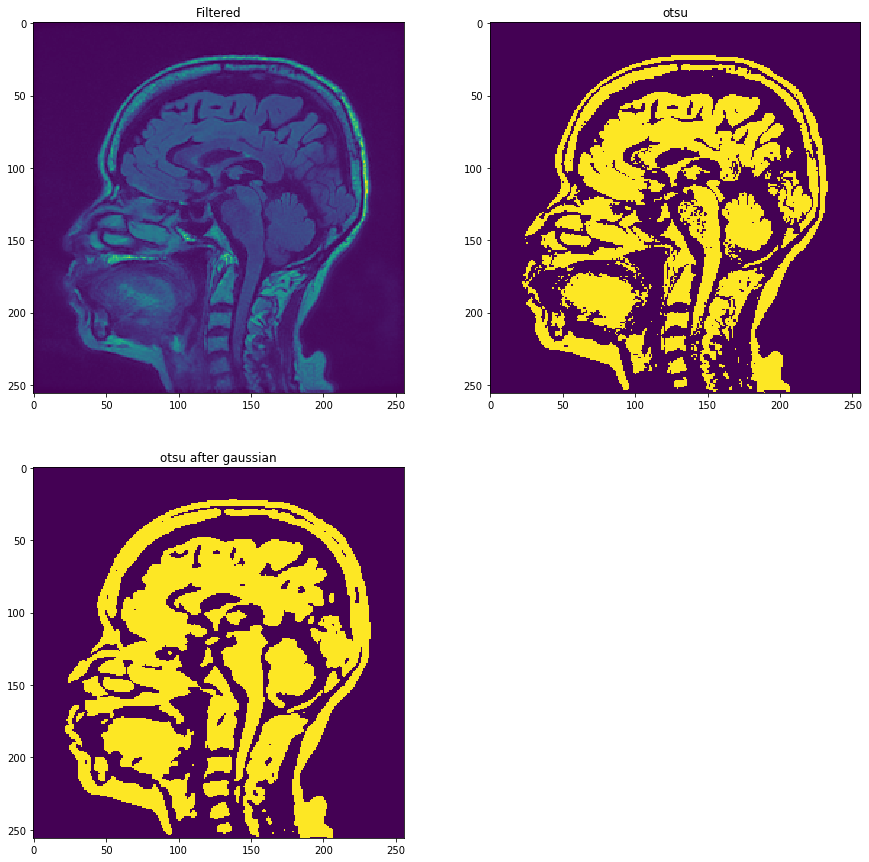

In [14]:
# global thresholding
ret1,th1 = cv2.threshold(hasil,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(hasil,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(hasil,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

fig=plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
plt.title("Filtered")
plt.imshow(hasil)
plt.subplot(2,2,2)
plt.title("otsu")
plt.imshow(th2)
plt.subplot(2,2,3)
plt.title("otsu after gaussian")
plt.imshow(th3)


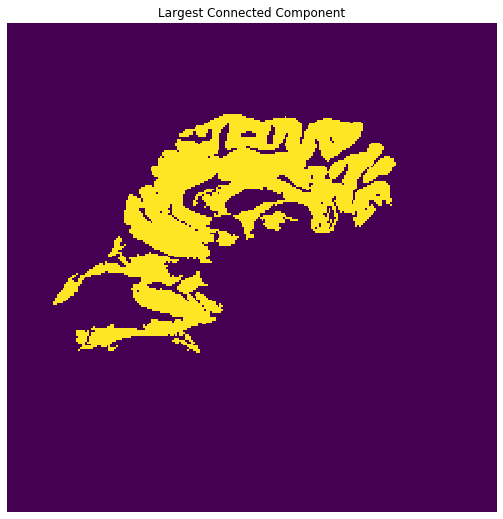

In [15]:
# LARGEST CONNECTED COMPONENT (LLC)
foreground_value = 255
mask = np.uint8(binarized == foreground_value)
labels, stats = cv2.connectedComponentsWithStats(mask, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
llc = np.zeros_like(binarized)
llc[labels == largest_label] = foreground_value
ShowImage('Largest Connected Component',llc,'rgb')

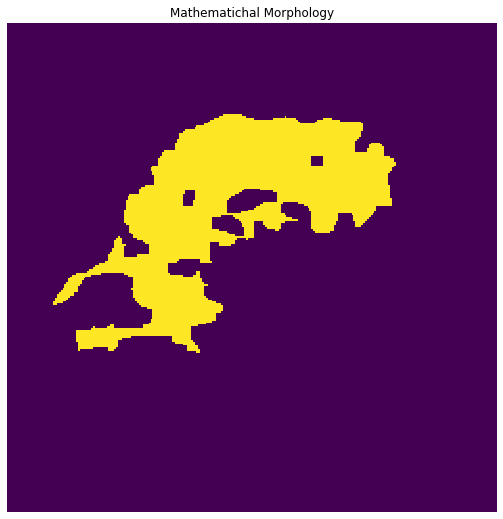

In [16]:
# Mathematical morphology (closing)
kernel = np.ones((5, 5), np.uint8)
llc_closing_image = cv2.morphologyEx(llc, cv2.MORPH_CLOSE, kernel)
ShowImage('Mathematichal Morphology',llc_closing_image,'rgb')

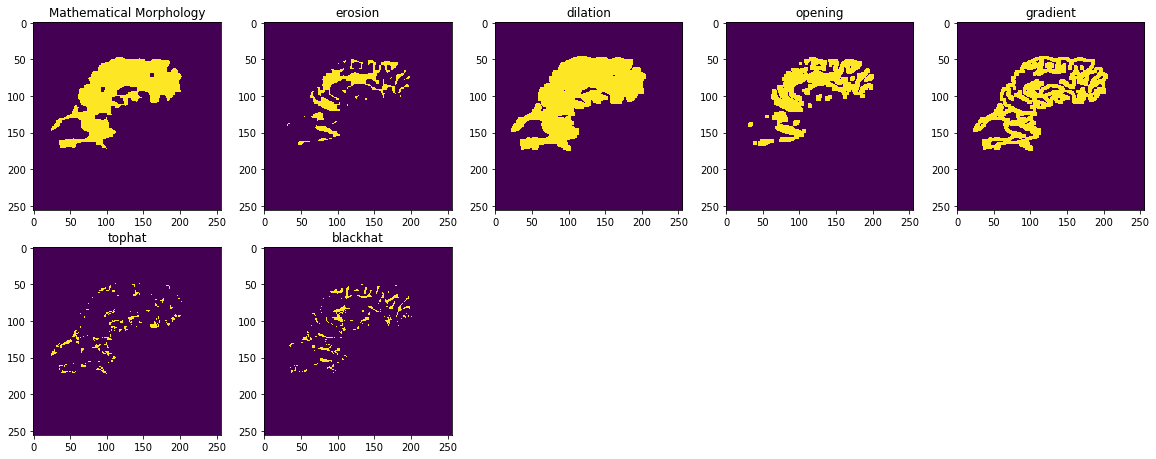

In [17]:
# erosion
kernel = np.ones((5, 5), np.uint8)
erosion = cv2.erode(llc,kernel,iterations = 1)

# dilation
kernel = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(llc,kernel,iterations = 1)

# opening
kernel = np.ones((5, 5), np.uint8)
opening = cv2.morphologyEx(llc, cv2.MORPH_OPEN, kernel)

# gradient
kernel = np.ones((5, 5), np.uint8)
gradient = cv2.morphologyEx(llc, cv2.MORPH_GRADIENT, kernel)

# tophat
kernel = np.ones((5, 5), np.uint8)
tophat = cv2.morphologyEx(llc, cv2.MORPH_TOPHAT, kernel)

# blackhat
kernel = np.ones((5, 5), np.uint8)
blackhat = cv2.morphologyEx(llc, cv2.MORPH_BLACKHAT, kernel)

fig=plt.figure(figsize=(20, 20))
plt.subplot(5,5,1)
plt.title("Mathematical Morphology")
plt.imshow(llc_closing_image)
plt.subplot(5,5,2)
plt.title("erosion")
plt.imshow(erosion)
plt.subplot(5,5,3)
plt.title("dilation")
plt.imshow(dilation)
plt.subplot(5,5,4)
plt.title('opening')
plt.imshow(opening)
plt.subplot(5,5,5)
plt.title("gradient")
plt.imshow(gradient)
plt.subplot(5,5,6)
plt.title("tophat")
plt.imshow(tophat)
plt.subplot(5,5,7)
plt.title('blackhat')
plt.imshow(blackhat)


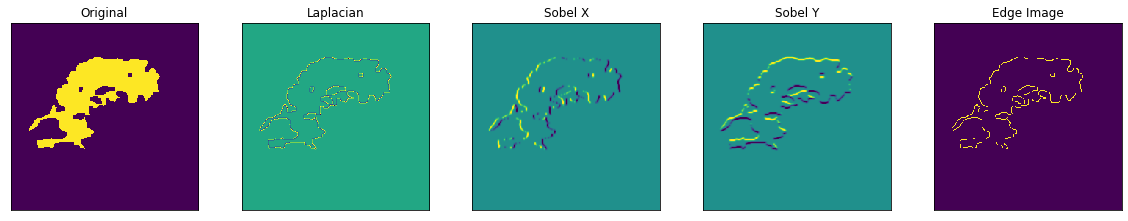

In [18]:
laplacian = cv2.Laplacian(llc_closing_image,cv2.CV_64F)
sobelx = cv2.Sobel(llc_closing_image,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(llc_closing_image,cv2.CV_64F,0,1,ksize=5)
edges = cv2.Canny(llc_closing_image,100,200)

fig=plt.figure(figsize=(20, 20))
plt.subplot(5,5,1),plt.imshow(llc_closing_image)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(5,5,2),plt.imshow(laplacian)
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(5,5,3),plt.imshow(sobelx)
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(5,5,4),plt.imshow(sobely)
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.subplot(5,5,5),plt.imshow(edges)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])


plt.show()

# Skull stripping

In [19]:
img_2d = file.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

#Skull Stripping
skull_stripped_image = cv2.bitwise_and(
    hasil, hasil, mask=llc_closing_image)
brain_pixels = skull_stripped_image[llc_closing_image == foreground_value]
print (brain_pixels, 'Brain Pixels')

# Adapting the data to K-means
kmeans_input = np.float32(brain_pixels.reshape(
    brain_pixels.shape[0], brain_pixels.ndim))
print(kmeans_input, 'Kmeans Input')

# K-means parameters
epsilon = 0.01
number_of_iterations = 50
number_of_clusters = 4
number_of_repetition = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            number_of_iterations, epsilon)
flags = cv2.KMEANS_RANDOM_CENTERS
print(criteria, 'criteria Paramaters')

# K-means segmentation
_, labels, centers = cv2.kmeans(
    kmeans_input, number_of_clusters, None, criteria,
    number_of_repetition, flags)
print(labels.shape, 'K-means segmentation')

# Adapting the labels
labels = labels.flatten('F')
for x in range(number_of_clusters):
    labels[labels == x] = centers[x]

[44 54 56 ... 44 44 43] Brain Pixels
[[44.]
 [54.]
 [56.]
 ...
 [44.]
 [44.]
 [43.]] Kmeans Input
(3, 50, 0.01) criteria Paramaters
(8745, 1) K-means segmentation


# Segmented image

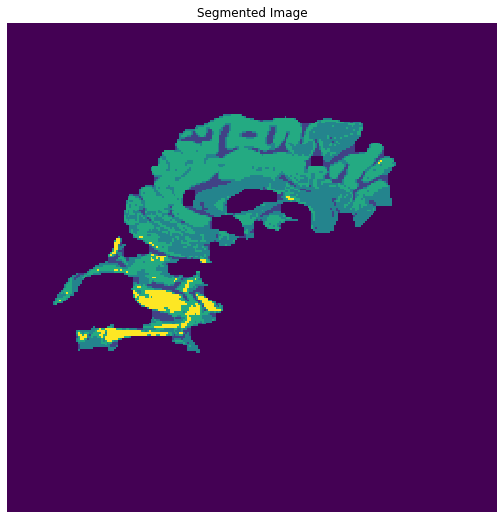

50
50


In [20]:
segmented_image = np.zeros_like(llc_closing_image)
segmented_image[llc_closing_image == foreground_value] = labels
ShowImage('Segmented Image',segmented_image,'rgb')
# plt.imshow(segmented_image)
print(segmented_image[100,100])
print(segmented_image[120,100])
# points = circle_points(200, [128, 128], 30)[:-1]
# snake = seg.active_contour(segmented_image, points)
# fig, ax = image_show(segmented_image)
# ax.plot(snake[:, 0], snake[:, 1], '-r', lw=3);

# felzenszwalb

(<Figure size 648x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b73ad49148>)

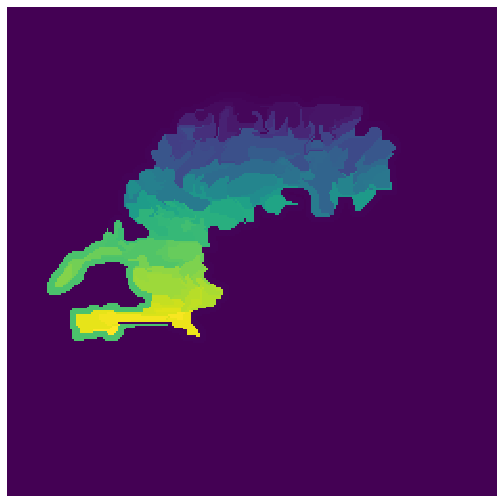

In [21]:
image_felzenszwalb = seg.felzenszwalb(segmented_image) 
image_show(image_felzenszwalb)

In [22]:
np.unique(image_felzenszwalb).size
3368

3368

In [23]:
image_felzenszwalb_colored = color.label2rgb(image_felzenszwalb, image, kind='avg')
image_show(image_felzenszwalb_colored)

NameError: name 'color' is not defined

# Match Template

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.feature import match_template

plt.imshow(image_felzenszwalb)
image = image_felzenszwalb
coin = image[170:220, 90:150]

result = match_template(image, coin)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

ax1.imshow(coin, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(image, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('image')

# highlight matched region
hcoin, wcoin = coin.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('match_template')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

In [ ]:
plt.hist(segmented_image)
gambar_otak = segmented_image
gambar_otak[segmented_image == segmented_image[100,90]]=segmented_image[100,110]
gambar_otak[segmented_image != segmented_image[100,90]]=0
ShowImage('Masking',gambar_otak,'rgb')
#plt.imshow(gambar_otak)

# marker_baru = segmented_image
# #Get the area taken by each component. Ignore label 0 since this is the background.
# marker_area = [np.sum(marker_baru==m) for m in range(np.max(marker_baru)) if m != 0]
# #Get label of largest component by area
# largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above                        
# #Get pixels which correspond to the brain
# brain_mask = marker_baru==largest_component
# otak = marker_baru.copy()
# #In a copy of the original image, clear those pixels that don't correspond to the brain
# # otak[brain_mask==False]=(0,0,0)
# otak[brain_mask == False] = 0
# # plt.imshow(otak)
# ShowImage('Masking',otak,'rgb')

In [ ]:
# # Display
# captions = ["1. Original image", "2. Thresholding",
#             "3. Largest connected component + Mathematical morphology",
#             "4. Segmented image"]
# horizontal_layout = np.hstack(
#     (hasil, binarized, llc_closing_image, segmented_image))
# cv2.imshow(" | ".join(captions), horizontal_layout)

# cv2.waitKey(0)

# Random Walker Algorithm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import random_walker
from skimage.exposure import rescale_intensity
import skimage

# Generate noisy synthetic data
data = gambar_otak.astype(float)
plt.hist(data)
data += 0.35 * np.random.randn(*data.shape)
markers = np.zeros(data.shape, dtype=np.uint)
markers[data < -0.3] = 1
markers[data > 150] = 2

# Run random walker algorithm
labels = random_walker(data, markers, beta=10, mode='bf')

# Plot results
plt.figure(figsize=(8, 3.2))
plt.subplot(131)
plt.imshow(data, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('Noisy data')
plt.subplot(132)
plt.imshow(markers, cmap='hot', interpolation='nearest')
plt.axis('off')
plt.title('Markers')
plt.subplot(133)
plt.imshow(labels, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('Segmentation')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)
plt.show()

In [ ]:
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np

blobs = gambar_otak

all_labels = measure.label(blobs)
blobs_labels = measure.label(blobs, background=0)

plt.figure(figsize=(9, 3.5))
plt.subplot(131)
plt.imshow(blobs, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.title('all labels')
plt.imshow(all_labels, cmap='nipy_spectral')
plt.axis('off')
plt.subplot(133)
plt.title('blobs')
plt.imshow(blobs_labels, cmap='nipy_spectral')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Generate noisy synthetic data
data = otak.astype(float)
plt.hist(data)
data += 0.35 * np.random.randn(*data.shape)
markers = np.zeros(data.shape, dtype=np.uint)
markers[data < 50] = 1
markers[data > 150] = 2

# Run random walker algorithm
labels = random_walker(data, markers, beta=10, mode='bf')

# Plot results
plt.figure(figsize=(8, 3.2))
plt.subplot(131)
plt.imshow(data, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('Noisy data')
plt.subplot(132)
plt.imshow(markers, cmap='hot', interpolation='nearest')
plt.axis('off')
plt.title('Markers')
plt.subplot(133)
plt.imshow(labels, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('Segmentation')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)
plt.show()

In [ ]:
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np

blobs = data

all_labels = measure.label(blobs)
blobs_labels = measure.label(blobs, background=0)

plt.figure(figsize=(9, 3.5))
plt.subplot(131)
plt.imshow(blobs, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.title('all labels')
plt.imshow(all_labels, cmap='nipy_spectral')
plt.axis('off')
plt.subplot(133)
plt.title('blobs')
plt.imshow(blobs_labels, cmap='nipy_spectral')
plt.axis('off')

plt.tight_layout()
plt.show()


# watershed & random walker segmentation

In [ ]:
import numpy as np
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage import measure
from skimage.segmentation import random_walker
import matplotlib.pyplot as plt
from scipy import ndimage

# # Generate an initial image with two overlapping circles
# x, y = np.indices((80, 80))
# x1, y1, x2, y2 = 28, 28, 44, 52
# r1, r2 = 16, 20
# mask_circle1 = (x - x1) ** 2 + (y - y1) ** 2 < r1 ** 2
# mask_circle2 = (x - x2) ** 2 + (y - y2) ** 2 < r2 ** 2
image = segmented_image
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance
# to the background
distance = ndimage.distance_transform_edt(image)
local_maxi = peak_local_max(
    distance, indices=False, footprint=np.ones((3, 3)), labels=image)
markers = measure.label(local_maxi)
labels_ws = watershed(-distance, markers, mask=image)

markers[~image] = -1
labels_rw = random_walker(image, markers)

plt.figure(figsize=(12, 3.5))
plt.subplot(141)
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('image')
plt.subplot(142)
plt.imshow(-distance, interpolation='nearest')
plt.axis('off')
plt.title('distance map')
plt.subplot(143)
plt.imshow(labels_ws, cmap='nipy_spectral', interpolation='nearest')
plt.axis('off')
plt.title('watershed segmentation')
plt.subplot(144)
plt.imshow(labels_rw, cmap='nipy_spectral', interpolation='nearest')
plt.axis('off')
plt.title('random walker segmentation')

plt.tight_layout()
plt.show()

# felzenszwalb

In [ ]:
image_felzenszwalb = seg.felzenszwalb(segmented_image) 
image_show(image_felzenszwalb);

In [ ]:
np.unique(image_felzenszwalb).size
3368

In [ ]:
import skimage.color as color 
image_felzenszwalb_colored = color.label2rgb(image_felzenszwalb, segmented_image, kind='avg')
image_show(image_felzenszwalb_colored);

# Making Trackbar

In [ ]:
# import cv2
# import numpy as np

# def nothing(x):
#     pass

# # Create a black image, a window
# img = np.zeros((300,512,3), np.uint8)
# cv2.namedWindow('image')

# # create trackbars for color change
# cv2.createTrackbar('R','image',0,255,nothing)
# cv2.createTrackbar('G','image',0,255,nothing)
# cv2.createTrackbar('B','image',0,255,nothing)

# # create switch for ON/OFF functionality
# switch = '0 : OFF \n1 : ON'
# cv2.createTrackbar(switch, 'image',0,1,nothing)

# while(1):
#     cv2.imshow('image',img)
#     k = cv2.waitKey(1) & 0xFF
#     if k == 27:
#         break

#     # get current positions of four trackbars
#     r = cv2.getTrackbarPos('R','image')
#     g = cv2.getTrackbarPos('G','image')
#     b = cv2.getTrackbarPos('B','image')
#     s = cv2.getTrackbarPos(switch,'image')

#     if s == 0:
#         img[:] = 0
#     else:
#         img[:] = [b,g,r]
        
# # cv2.waitKey(0)
# cv2.destroyAllWindows()
# # Image masking python opencv

In [ ]:
# from skimage import io
# basepath ="C:\\Users\\Asus\\Desktop\\tugas\\RPLB (python)\\"
# y=segmented_image
# # plt.imshow(y)
# plt.imsave(basepath + "hasil.jpeg", y, cmap="bone")
# image = cv2.imread(basepath + 'hasil.jpeg', 0)

In [ ]:
# import cv2
# import numpy as np
# panel = np.zeros([100,70,3], np.uint8)
# cv2.namedWindow("panel")

# def nothing(x):
#     print(x)
#     pass

# cv2.createTrackbar("L-h","panel", 0, 255, nothing)
# cv2.createTrackbar("U-h","panel", 179, 179, nothing)
# cv2.createTrackbar("L-s","panel", 0, 255, nothing)
# cv2.createTrackbar("U-s","panel", 255, 255, nothing)
# cv2.createTrackbar("L-v","panel", 0, 255, nothing)
# cv2.createTrackbar("U-v","panel", 255, 255, nothing)
# cap = cv2.VideoCapture('hasil.jpeg')

# while True:
#     img = cv2.imread('hasil.jpeg')
#     print(img)
#     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     l_h = cv2.getTrackbarPos("L-h", "panel")
#     u_h = cv2.getTrackbarPos("U-h", "panel")
#     l_s = cv2.getTrackbarPos("L-s", "panel")
#     u_s = cv2.getTrackbarPos("U-s", "panel")
#     l_v = cv2.getTrackbarPos("L-v", "panel")
#     u_v = cv2.getTrackbarPos("U-v", "panel")
#     low = np.array([l_h, l_s, l_v])
#     high = np.array([u_h, u_s, u_v])
#     mask = cv2.inRange(hsv, low, high)
#     mask_inv = cv2.bitwise_not(mask)
#     fg = cv2.bitwise_and(img, img, mask = mask)
#     bg = cv2.bitwise_and(img, img, mask = mask_inv)
#     cv2.imshow("fg", fg)
#     cv2.imshow("bg", bg)
#     k = cv2.waitKey(30)&0xFF
#     if k == 27:
#         break